In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import log, square, sqrt, power, arange, ones, zeros,\
    array, outer, pi, sin, cos, expand_dims, repeat, full, concatenate
from numpy.random import normal
from scipy.optimize import least_squares, minimize

In [2]:
class FlexibleFourierRegression():
    '''
    See P.152 Anderson(1997) Appendix B for details
    '''
    
    def __init__(self, N, J=0, P=0, di=[]):
        self.J = J
        self.D = len(di)
        self.P = P
        
        self.N = N
        self.di = di
        self.Id = zeros(shape=(N,))
        self.mu0 = ones(shape=(J+1,))
        self.mu1 = ones(shape=(J+1,))
        self.mu2 = ones(shape=(J+1,))
        self.lamb = ones(shape=(self.D,))
        self.gamma = ones(shape=(P, J+1))
        self.delta = ones(shape=(P, J+1))
        self.p = arange(1, P + 1, 1)
        self.x = concatenate([self.mu0.ravel(), self.mu1.ravel(), self.mu2.ravel(),
            self.lamb.ravel(), self.gamma.ravel(), self.delta.ravel()])    
        
    def train(self, y, sigma_t):
        '''Trains model using flexible fourier functional form.
        
        Parameters
        ----------
        y : dependent variable
        
        sigma: estimated conditional volatility for day t,
        sigma_t is scalar.
        
        Returns
        -------
        None
        '''
        assert y.shape[0] == self.N, "input y should have shape[0] == N:"
        n = arange(0, self.N, 1)
        J = self.J
        ## Learning weights for the following parameters
        ## self.mu0, self.mu1, self.mu2, self.lamb, self.gamma, self.delta
        
        def lsq_fun(x):
            
            mu0 = x[0: J+1]
            mu1 = x[J+1: 2*J+2]
            mu2 = x[2*J+2: 3*J+3]
            lamb = x[3*J+3:3*J+3+self.D]
            gamma = x[3*J+3+self.D: 3*J+3+self.D+self.P*(J+1)].reshape((self.P, J+1))
            delta = x[3*J+3+self.D+self.P*(J+1): 3*J+3+self.D+2*self.P*(J+1)].reshape((self.P, J+1))
            
            gamma = repeat(expand_dims(gamma, axis=0), self.N, axis=0)
            delta = repeat(expand_dims(delta, axis=0), self.N, axis=0)            
            N1 = (self.N + 1) / 2
            N2 = (self.N + 1) * (self.N + 2) / 6            
            
            dummy = self.Id.copy()
            dummy[self.di] = lamb
            dummy = repeat(expand_dims(dummy, axis=1), J+1, axis=1)
            
            mu0 = repeat(expand_dims(mu0, axis=0), self.N, axis=0)
            quad = mu0 + outer(n / N1, mu1) + outer(square(n) / N2, mu2)
            cosine = cos(2 * outer(n, self.p) * pi / self.N)
            sine = sin(2 * outer(n, self.p) * pi / self.N)
            cosine = repeat(expand_dims(cosine, axis=-1), J+1, axis=-1)
            sine = repeat(expand_dims(sine, axis=-1), J+1, axis=-1)  
            fourier_expand = gamma * cosine + delta * sine
            fourier = fourier_expand.sum(axis=1)

            sigma = full(fill_value=sigma_t, shape=(self.N, J+1))
            for j in range(J+1):
                sigma[:,j] = power(sigma[:,j], j)   

            result = (sigma * (quad + dummy + fourier)).sum(axis=1)
            cost = square(result - y).sum()
            
            return cost
        
        res = minimize(lsq_fun, self.x)
        
        self.mu0 = res.x[0: J+1]
        self.mu1 = res.x[J+1: 2*J+2]
        self.mu2 = res.x[2*J+2: 3*J+3]
        self.lamb = res.x[3*J+3:3*J+3+self.D]
        self.gamma = res.x[3*J+3+self.D: 3*J+3+self.D+self.P*(J+1)].reshape((self.P, J+1))
        self.delta = res.x[3*J+3+self.D+self.P*(J+1): 3*J+3+self.D+2*self.P*(J+1)].reshape((self.P, J+1))
        
        return res
        
    def predict(self, sigma_t):
        
        N = self.N
        D = self.D
        J = self.J
        P = self.P
        p = self.p
        
        gamma = repeat(expand_dims(self.gamma, axis=0), N, axis=0)
        delta = repeat(expand_dims(self.delta, axis=0), N, axis=0)
        n = arange(0, N, 1)
        N1 = (N + 1) / 2
        N2 = (N + 1) * (N + 2) / 6
        
        dummy = self.Id.copy()
        dummy[self.di] = self.lamb
        dummy = repeat(expand_dims(dummy, axis=1), J+1, axis=1)
        
        quad = self.mu0 + outer(n / N1, self.mu1) + outer(square(n) / N2, self.mu2)
        
        cosine = cos(2 * outer(n, self.p) * pi / N)
        sine = sin(2 * outer(n, self.p) * pi / N)
        cosine = repeat(expand_dims(cosine, axis=-1), J+1, axis=-1)
        sine = repeat(expand_dims(sine, axis=-1), J+1, axis=-1)
        fourier_expand = gamma * cosine + delta * sine
        fourier = fourier_expand.sum(axis=1)
        
        sigma = full(fill_value=sigma_t, shape=(self.N, J+1))
        for j in range(J+1):
            sigma[:,j] = power(sigma[:,j], j)   
            
        result = (sigma * (quad + dummy + fourier)).sum(axis=1)            
        return result

In [5]:
y = normal(1, 0.2, 240)
y[78], y[79], y[80] = 1.4, 1.2, 1.3
test = FlexibleFourierRegression(N=240, di=[78, 79, 80], J=5, P=15)
sigma_t = 0.2
res = test.train(y, sigma_t)
result = test.predict(sigma_t)

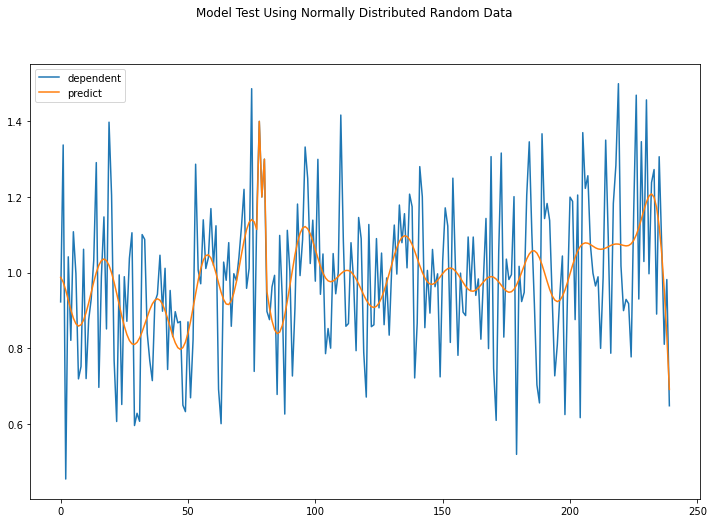

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(y, label="dependent")
ax.plot(result, label="predict")
ax.legend()
title = fig.suptitle("Model Test Using Normally Distributed Random Data")